In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PCA as pca
from scipy.optimize import minimize
from scipy.linalg import cho_factor, cho_solve
import emcee
import corner
%matplotlib inline

In [2]:
from modeling import Model
class SimpleKernel(Model):
    parameter_names = ("log_b", )
    
    def get_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return a * np.exp(-b * tau**2)
    
    def get_grad_1_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return 2 * a * b * tau * np.exp(-b * tau**2)
    
    def get_grad_2_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return 2 * a * b * np.exp(-b * tau**2) * (1.0 - 2 * b * tau**2)
    
class RVKernel(Model):
    parameter_names = ("vc", "vr", "lc", "bc", "br")
    
    def __init__(self, G, *args, **kwargs):
        self.G = G
        super(RVKernel, self).__init__(*args, **kwargs)
    
    def get_value(self, tau, l1, l2):
#         vc = np.exp(self.log_vc)
#         vr = np.exp(self.log_vr)
#         lc = np.exp(self.log_lc)
#         bc = np.exp(self.log_bc)
#         br = np.exp(self.log_br)
        vc = self.vc
        vr = self.vr
        lc = self.lc
        bc = self.bc
        br = self.br
        
        # Compute the value of gamma and its derivatives
        g = self.G.get_value(tau)
        gp1 = self.G.get_grad_1_value(tau)
        gp2 = self.G.get_grad_1_value(-tau)
        gpp = self.G.get_grad_2_value(tau)
        
        # We'll use these masks to build the blocked kernel matrix
        m11 = l1 == 1
        m12 = l1 == 2
        m13 = l1 == 3
        m21 = l2 == 1
        m22 = l2 == 2
        m23 = l2 == 3
        
        # Allocate the matrix and loop over blocks
        K = np.zeros_like(tau)
        zero_tau = np.isclose(tau, 0.0)
        
        # k11
        m = m11 * m21
        K[m] = vc**2*g[m] + vr**2*gpp[m] + vr*vc*(gp1 + gp2)[m]
        m &= zero_tau

        # k22
        m = m12 * m22
        K[m] = lc**2*g[m]
        m &= zero_tau

        # k33
        m = m13 * m23
        K[m] = bc**2*g[m] + br**2*gpp[m] + bc*br*(gp1 + gp2)[m]
        m &= zero_tau

        # k12
        m = m11 * m22
        K[m] = vc*lc*g[m] + vr*lc*gp2[m]
        m = m12 * m21
        K[m] = vc*lc*g[m] + vr*lc*gp1[m]

        # k13
        m = m11 * m23
        K[m] = vc*bc*g[m] + vr*br*gpp[m] + vc*br*gp1[m] + vr*bc*gp2[m]
        m = m13 * m21
        K[m] = vc*bc*g[m] + vr*br*gpp[m] + vc*br*gp2[m] + vr*bc*gp1[m]

        # k23
        m = m12 * m23
        K[m] = lc*bc*g[m] + lc*br*gp1[m]
        m = m13 * m22
        K[m] = lc*bc*g[m] + lc*br*gp2[m]

        return K

In [3]:
# Get PCA of simulated spectra
dir_ = "simulated_spectra/"   # data directory
pcs = 3                       # number of pca components
WL = (3924, 6662)             # single range

x, v, z, xs_hat, x_hat, wavelengths, ev = pca.do_PCA(dir_, WL, pcs, 1)

Successfully loaded files
3 PCs explain 0.997743 of the variance for wavelimits:. (3924, 6662)


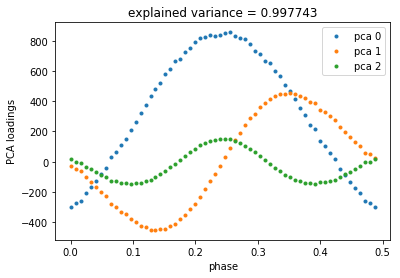

In [4]:
phases = np.load('files/phases.npy')

# cut index
index = (phases > -0.25)&(phases < 0.25)
z = z[index]
phases = phases[index]

phases -= np.min(phases)
for i in range(pcs):
    plt.plot(phases, z[:,i], '.', label='pca %d'%i)
plt.ylabel('PCA loadings')
plt.xlabel('phase')
plt.title('explained variance = %f'%ev)
plt.legend()

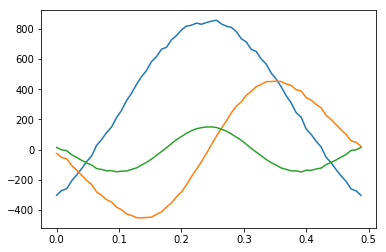

In [11]:
# Prepare Data
n = len(z)

# indices
l = np.zeros(0)
p = np.zeros(0)
y = np.zeros(0)
for i in range(pcs):
    l = np.concatenate((l, np.ones(n)*(i+1)))
    p = np.concatenate((p, phases))
    y = np.concatenate((y, z[:, i]))

for i in range(pcs):
    plt.plot(phases, y[l==i+1])

In [12]:
def log_prob(params, y, p, l):
    n = func.vector_size
    func.set_parameter_vector(params[:n])
    kernel.set_parameter_vector(params[n:])
    K = kernel.get_value(p[:, None] - p[None, :], l[:, None], l[None, :])
    K[np.diag_indices_from(K)] += 0.1
    try:
        L = cho_factor(K, overwrite_a=True)
    except (np.linalg.LinAlgError, ValueError):
        return -np.inf
    logdet = 2.0 * np.sum(np.log(np.diag(L[0])))
    ll = -0.5 * (np.dot(y, cho_solve(L, y)) + logdet)
    if not np.isfinite(ll):
        return -np.inf
    return ll

In [13]:
# initial conditions
func = SimpleKernel(0.01)
kernel = RVKernel(func, 1.0, 1.0, 0.6, 0.3, 0.5)

In [14]:
nwalkers, ndim, nsteps = 50, func.vector_size + kernel.vector_size, 2000
p0 = np.append(func.get_parameter_vector(), kernel.get_parameter_vector())
p0 = 1e-5*np.random.randn(nwalkers, len(p0))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(y, p, l))

In [15]:
for i, (pos, lnp, state) in enumerate(sampler.sample(p0, iterations=nsteps)):
    if (i+1) % (nsteps/10) == 0:
        print("{0:.1f}%".format(100 * float(i) / nsteps), end=", ")

5.0%, 9.9%, 14.9%, 19.9%, 24.9%, 29.9%, 35.0%, 40.0%, 45.0%, 50.0%, 55.0%, 60.0%, 65.0%, 70.0%, 75.0%, 80.0%, 85.0%, 90.0%, 95.0%, 100.0%, 

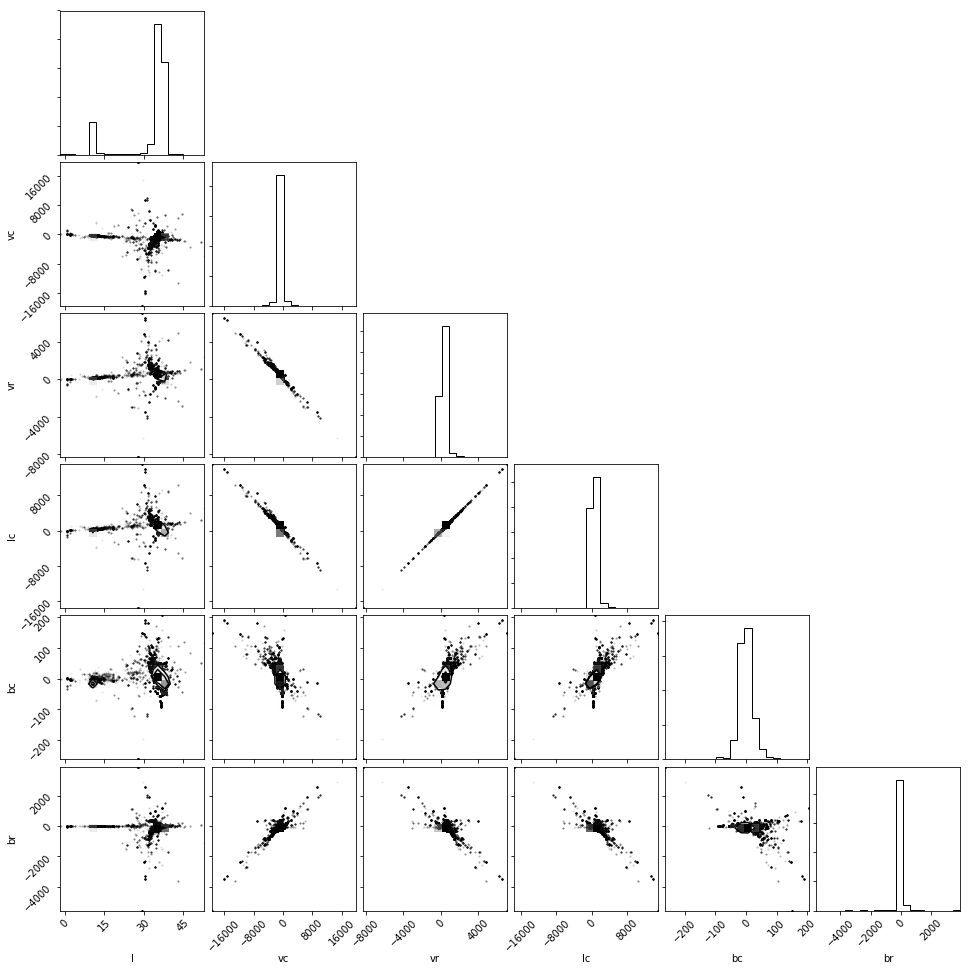

In [16]:
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["l", "vc", "vr", "lc", "bc", "br"])

[  37.2920592  -260.4255127   141.21812718  322.3674498   -51.58640239
   25.62186911]


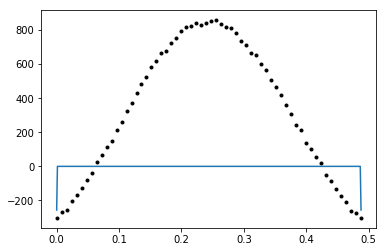

In [17]:
params = samples[-1]
print(params)
n = func.vector_size
func.set_parameter_vector(params[:n])
kernel.set_parameter_vector(params[n:])

K = kernel.get_value(p[:, None] - p[None, :], l[:, None], l[None, :])
K[np.diag_indices(len(p))] += 0.1

x = np.linspace(0, max(phases), 400)
Ks = kernel.get_value(x[:, None] - p[None, :], 1+np.zeros(len(x), dtype=int)[:, None], l[None, :])

mu = np.dot(Ks, np.linalg.solve(K, y))

plt.plot(p[l==1], y[l==1], ".k")
plt.plot(x, mu)